In [89]:
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.generators.random_graphs import erdos_renyi_graph, complete_graph
from networkx.generators import circulant_graph

def make_cirvular_graph(N):
    G = nx.circulant_graph(N, [1])
    return nx.adjacency_matrix(G).todense()

def make_complete_graph(N):
    G = nx.complete_graph(N)
    return nx.adjacency_matrix(G).todense()

def make_random_graph(N, occupancy=0.5):
    G = nx.complete_graph(N)
    fixed_edges = []
    edges = list(G.edges)
    num_of_edges = len(edges)
    vanish_rate = int(np.round(num_of_edges*occupancy))
    if vanish_rate < N:
        print("vanish_rate lover than N", vanish_rate, " ", N)
        return
    for i in range(vanish_rate):
        # TODO: make this more optimal
        while True:
            edge = edges[random.randint(0, num_of_edges-1)]
            if edge not in fixed_edges:
                G.remove_edge(edge[0], edge[1])
            if nx.is_connected(G):
                edges.remove(edge)
                num_of_edges -= 1
                break
            else:
                G.add_edge(edge, weight=1)
                fixed_edges.append(edge)
    return nx.adjacency_matrix(G).todense()

def vanish_random_edge(M):
    G = nx.from_numpy_matrix(M)
    fixed_edges = []
    edges = list(G.edges)
    num_of_edges = len(edges)
    # TODO: make this more optimal
    while True:
        edge = edges[random.randint(0, num_of_edges-1)]
        if edge not in fixed_edges:
            G.remove_edge(edge[0], edge[1])
        if nx.is_connected(G):
            edges.remove(edge)
            num_of_edges -= 1
            break
        else:
            G.add_edge(edge[0], edge[1], weight=1)
            fixed_edges.append(edge)
    return fill_metropolis_weigts(nx.adjacency_matrix(G).todense())

def fill_metropolis_weigts(M):
    n_links = []
    for i in range(len(M)):
        n_links.append(np.count_nonzero(M[i]))
    G = nx.from_numpy_matrix(M)
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = 1 / max(n_links[u], n_links[v])
    return nx.adjacency_matrix(G).todense()

def make_graph_img(M, num_of_lines = 5, fig_size=(5, 5)):
    G = nx.from_numpy_matrix(M)
    _w = []
    _step = 1 / num_of_lines
    w_08 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= 0.8]
    for i in range(num_of_lines):
        _w.append([(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > i * _step and d["weight"] <= (i+1)*_step])

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    edge_labels = nx.get_edge_attributes(G, "weight")
    for key in edge_labels:
        edge_labels[key] = np.round(edge_labels[key], 2)

    plt.figure(figsize=fig_size, dpi=80)

    nx.draw_networkx_nodes(G, pos, node_size=700)

    for i in range(num_of_lines):
        nx.draw_networkx_edges(G, pos, edgelist=_w[i], width=4, alpha=(i+1)*_step)

    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [95]:
import torch
from sklearn.datasets import make_classification
import random
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.generators import circulant_graph

def Fenchel(z):
    return torch.sum(torch.abs(z)*torch.log(torch.abs(z)) + (1 - torch.abs(z))*torch.log(1 - torch.abs(z)))

def dual_grad(z_):
    return torch.autograd.grad(Fenchel(z_), z_)

def adom_iteration(z, z_f, mu, alpha, nu, theta, sigma, tau, W, y):
    z_g = tau*z + (1 - tau)*z_f
    gr = dual_grad(z_g)[0]
    delta = torch.sum(sigma*W*(mu - nu*dual_grad(z_g)[0]), 1)
    mu = mu - nu*dual_grad(z_g)[0] - delta
    z = z + nu*alpha*(z_g - z) + delta
    z_f = z_g - torch.sum(theta*W*dual_grad(z_g)[0], 1)
    
    return z, z_g, z_f

def ADOM(W, X, y, mu_, L):
    """
    stop_criterion
    W - graph matrix
    x - features
    y - labels
    mu_ - strong convex constant
    L - convex constant
    """

    z = torch.tensor(torch.rand(10), requires_grad=True)
    mean, std = torch.mean(z), torch.std(z)
    z  = (z-mean)
    z_f = torch.empty_like(z).copy_(z)

    mu = torch.tensor(torch.from_numpy(np.full(10, np.random.random_sample())), requires_grad=True)
    mu_ = mu_
    L = L
    alpha = 1/(2*L)
    lambda_min_positive = min(np.extract(np.linalg.eigvals(W)>0, np.linalg.eigvals(W)))
    nu = torch.tensor(torch.from_numpy(np.array(2*lambda_min_positive*math.sqrt(mu_*L)/(7*max(np.linalg.eigvals(W))))), requires_grad=True)
    theta = mu_/max(np.linalg.eigvals(W))
    tau = lambda_min_positive*math.sqrt(mu_/L)/(7*max(np.linalg.eigvals(W)))
    sigma = theta/mu_

    W = W.astype(float)
    W = torch.tensor(W, requires_grad = True)
    F = []
    i = 0
    while(i != -1):
        z, z_g, z_f = adom_iteration(z, z_f, mu, alpha, nu, theta, sigma, tau, W, y)
        F.append(Fenchel(z_g))
        if ((i > 2) and ((F[i] > F[i-1]) and (F[i-1] > F[i-2]))): i = -1
        else: i+=1
    return z, z_g, z_f, F

In [91]:
N = 10
W = make_random_graph(N)
W = fill_metropolis_weigts(W)
n_samples, n_features = 10, 10
rng = np.random.RandomState(0)
X, y = make_classification(n_samples, n_features, random_state=rng)
X = torch.tensor(torch.from_numpy(X), requires_grad=True)
np.random.seed(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [92]:
y = ((y - 0.5)*2)

In [93]:
y = y.astype(int)

In [96]:
z, z_g, z_f, F = ADOM(W, X, y, 0.001, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


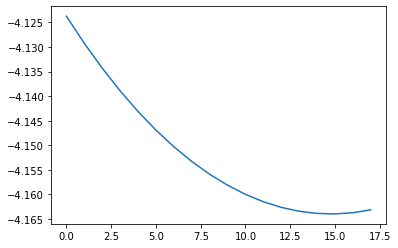

In [97]:
import matplotlib.pyplot as plt
plt.plot([i.detach().numpy() for i in F])
plt.show()